# Statistics for wine volume regression model

Mean absolute error (MAE) for laboratory images of glasses and cups model.

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop
# User parameters to set
TIMESTAMP = '2024-02-01_115602'                       # timestamp of the model
MODEL_NAME = 'epoch-20.hdf5'
#MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP


### Load the prediction data

In [2]:
import pandas as pd
# Load back the predictions
SPLIT_NAME='test'
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

df_pred=pd.DataFrame(pred_dict)
df_pred['abs_error']=abs(df_pred.pred_value-df_pred.true_value)

### Prepare dataframes

I had implement a function that get the true_weights of the images and return the bin at which it belong

In [3]:
def get_bin(true_values):
    
    grams = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375]
    bins = [87.5, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 262.5, 287.5, 312.5, 337.5, 362.5, 387.5]
    
    result = list()
    for e in true_values:
        l = len(bins)
        index = 0
        for i in range(l):
            try:
                if bins[i] < float(e) and bins[i+1] > float(e):
                    index = i
                    result.append(grams[index])
                    break
            except:
                print(e)
    
    return result

Extract all the data from images to dataframe

In [4]:
["location", "fruta", "variedad", "tamaño", "plato", "luz", "plano", "angulo"]
# extract values of angle, plane and background in all images
df_pred['location'] = df_pred.apply(lambda row: row.filenames.split('_')[0].split('/')[-1], axis=1)
df_pred['variety'] = df_pred.apply(lambda row: row.filenames.split('_')[2], axis=1)
df_pred['size'] = df_pred.apply(lambda row: row.filenames.split('_')[3].replace(',','.'), axis=1)
df_pred['plate'] = df_pred.apply(lambda row: row.filenames.split('_')[4], axis=1)
df_pred['light'] = df_pred.apply(lambda row: row.filenames.split('_')[5], axis=1)
df_pred['shot'] = df_pred.apply(lambda row: row.filenames.split('_')[6], axis=1)
df_pred['angle'] = df_pred.apply(lambda row: row.filenames.split('_')[7].split('.')[0], axis=1)
df_pred.head(5)

,filenames,pred_value,true_value,abs_error,location,variety,size,plate,light,shot,angle
0,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",168.391998,171.740005,3.348007,Mad,Granny Smith,171.74,Pgb,ext,al,cen
1,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",203.647141,171.740005,31.907135,Mad,Granny Smith,171.74,Pgb,ext,al,sup
2,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",183.555725,171.740005,11.815720,Mad,Granny Smith,171.74,Pgb,ext,ce,cen
3,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",198.464218,171.740005,26.724213,Mad,Granny Smith,171.74,Pgb,ext,ce,sup
4,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",206.743469,171.740005,35.003464,Mad,Granny Smith,171.74,Pgb,ext,ce,ver


Change the size to the bin_size

In [5]:
df_pred['size']=pd.to_numeric(df_pred['size'])
df_pred['size']=get_bin(df_pred['size'])
df_pred['rel_error']=df_pred.abs_error/df_pred.size
df_pred.head(5)

,filenames,pred_value,true_value,abs_error,location,variety,size,plate,light,shot,angle,rel_error
0,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",168.391998,171.740005,3.348007,Mad,Granny Smith,175,Pgb,ext,al,cen,0.000142
1,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",203.647141,171.740005,31.907135,Mad,Granny Smith,175,Pgb,ext,al,sup,0.001353
2,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",183.555725,171.740005,11.815720,Mad,Granny Smith,175,Pgb,ext,ce,cen,0.000501
3,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",198.464218,171.740005,26.724213,Mad,Granny Smith,175,Pgb,ext,ce,sup,0.001133
4,"/storage/MANZANA/Granny Smith/171,74/Mad_M_Gra...",206.743469,171.740005,35.003464,Mad,Granny Smith,175,Pgb,ext,ce,ver,0.001484


In [6]:
print(df_pred[df_pred['variety'] == "Fuji"])

                                              filenames  pred_value  \
64    /storage/MANZANA/Fuji/210.58/Rio_M_Fuji_210,58...  202.032486   
65    /storage/MANZANA/Fuji/210.58/Rio_M_Fuji_210,58...  185.545471   
66    /storage/MANZANA/Fuji/210.58/Rio_M_Fuji_210,58...  213.087311   
67    /storage/MANZANA/Fuji/210.58/Rio_M_Fuji_210,58...  221.406204   
68    /storage/MANZANA/Fuji/210.58/Rio_M_Fuji_210,58...  216.438141   
...                                                 ...         ...   
1995  /storage/MANZANA/Fuji/320.09/Rio_M_Fuji_320,09...  239.166733   
1996  /storage/MANZANA/Fuji/320.09/Rio_M_Fuji_320,09...  253.304459   
1997  /storage/MANZANA/Fuji/320.09/Rio_M_Fuji_320,09...  252.797913   
1998  /storage/MANZANA/Fuji/320.09/Rio_M_Fuji_320,09...  256.273926   
1999  /storage/MANZANA/Fuji/320.09/Rio_M_Fuji_320,09...  246.792282   

      true_value  abs_error location variety  size plate light shot angle  \
64    210.580002   8.547516      Rio    Fuji   200   Pgb   ext   al   

In [24]:
def Mae_plot_by_variety(df, variety = None):
    
    img_name = 'abs_error.png'
    if variety != None:
        df = df[df['variety'] == variety]
        img_name = 'abs_error_'+variety+'.png'
    
    # groups
    df_variety=df.groupby(['variety'], as_index=False)['abs_error'].mean()
    df_size=df.groupby(['size'], as_index=False)['abs_error'].mean()
    df_plate=df.groupby(['plate'], as_index=False)['abs_error'].mean()
    df_light=df.groupby(['light'], as_index=False)['abs_error'].mean()
    df_shot=df.groupby(['shot'], as_index=False)['abs_error'].mean()
    df_angle=df.groupby(['angle'], as_index=False)['abs_error'].mean()
    df_location=df.groupby(['location'], as_index=False)['abs_error'].mean()
    
    #Calculate Standar Desviation
    # the codeline generate a subdataframe with columns = [characteristic, abs_error] but in reality it is  [characteristic, std]
    df_variety['std']=df.groupby(['variety'], as_index=False)['abs_error'].std()['abs_error']
    df_size['std']=df.groupby(['size'], as_index=False)['abs_error'].std()['abs_error']
    df_plate['std']=df.groupby(['plate'], as_index=False)['abs_error'].std()['abs_error']
    df_light['std']=df.groupby(['light'], as_index=False)['abs_error'].std()['abs_error']
    df_shot['std']=df.groupby(['shot'], as_index=False)['abs_error'].std()['abs_error']
    df_angle['std']=df.groupby(['angle'], as_index=False)['abs_error'].std()['abs_error']
    df_location['std']=df.groupby(['location'], as_index=False)['abs_error'].std()['abs_error']
    
    custom_dict = {'Mad': 0, 'Rio': 1}
    df_location=df_location.sort_values(by=['location'], key=lambda x: x.map(custom_dict))
    custom_dict = {'Fuji': 0, 'Golden': 1, 'Granny Smith': 2}
    df_variety=df_variety.sort_values(by=['variety'], key=lambda x: x.map(custom_dict))
    custom_dict = {'Spb': 0, 'Spo': 1, 'Spm': 2, 'Ppb': 3, 'Pgb': 4}
    df_plate=df_plate.sort_values(by=['plate'], key=lambda x: x.map(custom_dict))
    custom_dict = {'int': 0, 'ext': 1}
    df_light=df_light.sort_values(by=['light'], key=lambda x: x.map(custom_dict))
    custom_dict = {'ce': 0, 'me': 1, 'al': 2}
    df_shot=df_shot.sort_values(by=['shot'], key=lambda x: x.map(custom_dict))
    custom_dict = {'sup': 0, 'cen': 1, 'ver': 2}
    df_angle=df_angle.sort_values(by=['angle'], key=lambda x: x.map(custom_dict))
    
    # rename values 
    df_plate['plate'].loc[(df_plate['plate'] == 'Spb')] = 'Blanco'
    df_plate['plate'].loc[(df_plate['plate'] == 'Spo')] = 'Oscuro'
    df_plate['plate'].loc[(df_plate['plate'] == 'Spm')] = 'Mantel'
    df_plate['plate'].loc[(df_plate['plate'] == 'Ppb')] = 'Plato Postre'
    df_plate['plate'].loc[(df_plate['plate'] == 'Pgb')] = 'Plato Grande'

    df_location['location'].loc[(df_location['location'] == 'Mad')] = 'Madrid'
    df_location['location'].loc[(df_location['location'] == 'Rio')] = 'Rioja'

    df_shot['shot'].loc[(df_shot['shot'] == 'al')] = '[50, 70]'
    df_shot['shot'].loc[(df_shot['shot'] == 'me')] = '[20, 30]'
    df_shot['shot'].loc[(df_shot['shot'] == 'ce')] = '[10, 15]'

    df_angle['angle'].loc[(df_angle['angle'] == 'sup')] = '(30, 60)'
    df_angle['angle'].loc[(df_angle['angle'] == 'cen')] = '0'
    df_angle['angle'].loc[(df_angle['angle'] == 'ver')] = '(90)'

    df_light['light'].loc[(df_light['light'] == 'int')] = 'indoors'
    df_light['light'].loc[(df_light['light'] == 'ext')] = 'outdoors'
    
    
    ###### GENERAR PLOT ######
    figsize = 5
    fig, axs = plt.subplots(3, 3, figsize=(figsize*3, figsize*3))
    gs = axs[0, 0].get_gridspec()
    fig.suptitle(f'MAE of "{variety}" variety', fontsize=24, y=0.97) #Titulo General TODO: Probar.
    # remove the underlying axes
    for ax in axs[0, 0:-1]:
        ax.remove()
    axbig = fig.add_subplot(gs[0, 0:-1])

    #y_error = df_size['abs_error']* (df_size['std']/100) #TODO Preguntar esta bien std/100??
    y_error = df_size['std']
    y_error = y_error.set_axis(df_size['size'])

    df_size.plot.bar(x='size', y='abs_error', yerr='std', ax=axbig, color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axbig.set_xlabel('Peso (g)', fontsize=18)
    axbig.set_ylabel('MAE (g)', fontsize=18)
    axbig.tick_params(axis='x', rotation=0)
    axbig.tick_params(axis='both', which='major', labelsize=16)
    axbig.yaxis.grid(True)

    df_plate.plot.bar(x='plate', y='abs_error', yerr='std', ax=axs[0,2], color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axs[0,2].set_xlabel('Plate', fontsize=18)
    axs[0,2].set_ylabel('MAE (g)', fontsize=18)
    axs[0,2].tick_params(axis='x', rotation=0)
    axs[0,2].tick_params(axis='both', which='major', labelsize=9)

    gs = axs[1, 0].get_gridspec()
    # remove the underlying axes
    for ax in axs[1, 0:-1]:
        ax.remove()
    axbig2 = fig.add_subplot(gs[1, 0:-1])

    df_variety.plot.bar(x='variety', y='abs_error', yerr='std', ax=axbig2, color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axbig2.set_xlabel('Variety', fontsize=18)
    axbig2.set_ylabel('MAE (g)', fontsize=18)
    axbig2.tick_params(axis='x', rotation=0)
    axbig2.tick_params(axis='both', which='major', labelsize=16)

    df_location.plot.bar(x='location', y='abs_error', yerr='std', ax=axs[1,2], color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axs[1,2].set_xlabel('location', fontsize=18)
    axs[1,2].set_ylabel('MAE (g)', fontsize=18)
    axs[1,2].tick_params(axis='x', rotation=0)
    axs[1,2].tick_params(axis='both', which='major', labelsize=16)

    df_angle.plot.bar(x='angle', y='abs_error', yerr='std', ax=axs[2,0], color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axs[2,0].set_xlabel('Angle (deg)', fontsize=18)
    axs[2,0].set_ylabel('MAE (g)', fontsize=18)
    axs[2,0].tick_params(axis='x', rotation=0)
    axs[2,0].tick_params(axis='both', which='major', labelsize=16)

    df_shot.plot.bar(x='shot', y='abs_error', yerr='std', ax=axs[2,1], color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axs[2,1].set_xlabel('Object distance (cm)', fontsize=18)
    axs[2,1].set_ylabel('MAE (g)', fontsize=18)
    axs[2,1].tick_params(axis='x', rotation=0)
    axs[2,1].tick_params(axis='both', which='major', labelsize=16)

    df_light.plot.bar(x='light', y='abs_error', yerr='std', ax=axs[2,2], color=['#355c70'], ecolor='r', capsize=7, legend=None)
    axs[2,2].set_xlabel('Lighting', fontsize=18)
    axs[2,2].set_ylabel('MAE (g)', fontsize=18)
    labels = [item.get_text() for item in axs[2,2].get_xticklabels()]
    labels[0] = 'indoors'
    labels[1] = 'outdors'
    axs[2,2].set_xticklabels(labels)
    axs[2,2].tick_params(axis='x', rotation=0)
    axs[2,2].tick_params(axis='both', which='major', labelsize=16)

    # for ax in axs:
    #    ax.tick_params(axis='both', which='major', labelsize=16)

    fig.tight_layout(pad=3.0)
    
    plt.savefig('/srv/image-results/'+img_name ,bbox_inches='tight')

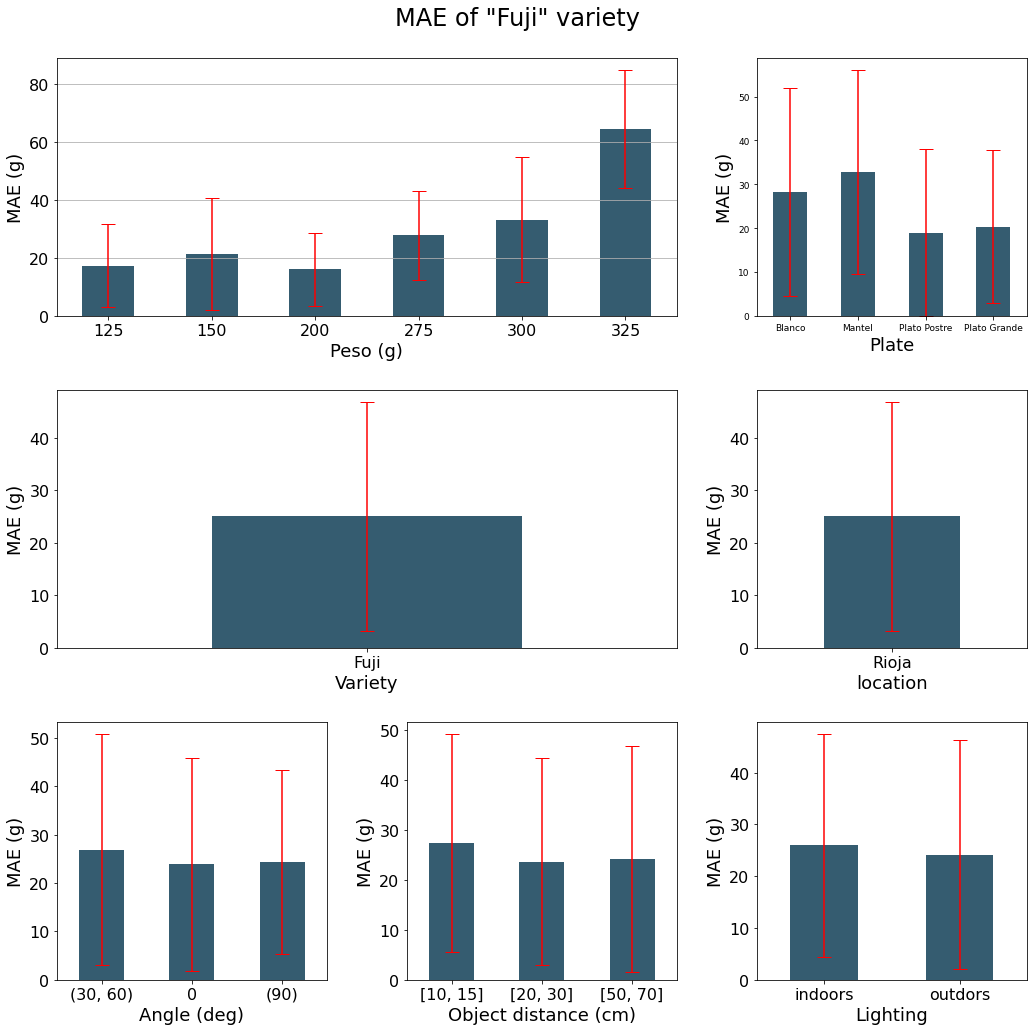

In [27]:
Mae_plot_by_variety(df_pred, "Fuji")